# Recreating Analysis of Piao Nature 2008

In [85]:
# Import modules
import pandas as pd
import numpy as np
from copy import deepcopy
import datetime
from ccgcrv import ccg_dates

In [86]:
# Get the datetime and a formated string
dt = datetime.datetime.now()
dtp = dt.strftime('%y%m%d-%H%M%S')

**Options**

co2_avg_freq: sets if data at higher freqencies should be averaged (e.g. to daily or monthly) before applying ccgcrv. Data at lower frequency is used as is.

In [87]:
# Options - general
name = dtp
data_dir = '../data/piao_2008/'

# Raw data files

# Options for preprocessing
do_co2proc = False

# Options for ccgcrv
co2_avg_freq = 'monthly' # one of: 'raw', 'daily', 'monthly' (Should deprecate. Only makes sense to use monthly)
start = 'start_total' # one of: start_total, start_piao2008
end = 'end_total'
# start = 'start_piao2008' # one of: start_total, start_piao2008
# end = 'end_piao2008'

# Options for temperature means
recalc_tmps = False
tmp_per_station = False # Calculate a different mean for each stations (see Piao 2008) or use single mean
tmp_latS = 20 # Southern limit for tmp mean
tmp_latN = 60 # Northern limit for tmp mean
excl_grnlnd = True # exclude Greenland

# Options for analysis
corr_station='BRW' # station to correlate and plot
corr_start = 'start_piao2008' 
corr_end = 'end_piao2008'
# corr_start = 1970
# corr_end = 1995
# corr_start = 1996
# corr_end = 2020
corr_start = 1970
corr_end = 1980
detrend = False # Should time series of temperature, AZC, etc be detrended before correlations


## Step 1: data retrieval

CO2 data from the stations used in Piao (and others) was retrieved from 2 sources: NOAA-ESRL and ICOS. Selection of Piao stations copied to: /Users/moyanofe/Work/Augsburg/Research/CO2/data/piao_2008

Data with Piao stations was then merged into files:
- piao2008_co2_datalask.csv (has event and monthly data)
- piao2008_co2_insitu_daily.csv
- piao2008_co2_insitu_hourly.csv
- piao2008_co2_insitu_monthly.csv

Analyses to carry out:
- First analysis: select stations and periods as in Piao 2008
- Second analysis: select stations as in Piao 2008 and entire available periods 
- Third analysis: use stations selected in Forkel 2016 with full time series


## Step 2: CO2 data preprocessing

**Data selection steps:**

Piao 2008 say they used flask data, but at least for Pt Barrow they used in-situ.  
There is no information about the frequency (daily vs monthly).

Approach 1:

- Use in-situ monthly where available (this is what Piao did for Pt Barrow)
- Average other data to daily and then to monthly values 

In [88]:
if do_co2proc:
    
        # Read on the co2 data
        co2_fm = pd.read_csv(data_dir + 'piao2008_co2_flask_monthly.csv')
        co2_fe = pd.read_csv(data_dir + 'piao2008_co2_flask_event.csv')
        co2_im = pd.read_csv(data_dir + 'piao2008_co2_insitu_monthly.csv')

        # Assign missing values (usually marked with -9999 or similar)
        co2_fm.loc[co2_fm['co2'] < 0, 'co2'] = np.nan
        co2_fe.loc[co2_fe['co2'] < 0, 'co2'] = np.nan
        co2_im.loc[co2_im['co2'] < 0, 'co2'] = np.nan

        # One station has two names: SSL and SCH. Set all to SSL (newer name)
        co2_fm.loc[co2_fm['station'] == 'SCH', 'station'] = 'SSL'
        co2_fe.loc[co2_fe['station'] == 'SCH', 'station'] = 'SSL'
        co2_im.loc[co2_im['station'] == 'SCH', 'station'] = 'SSL'

        # Drop unused columns
        co2_fm.drop('stdev', inplace=True, axis=1)
        co2_fe.drop('stdev', inplace=True, axis=1)

        # Get daily averages from event data and remove the averaged hour column
        co2_fe2d = co2_fe.groupby(['station','year','month','day'], as_index=False).mean()
        co2_fe2d.drop(['hour'], axis=1, inplace=True)

        # Get monthly averages from daily means and remove unnecessary columns
        co2_fe2m = co2_fe2d.groupby(['station','year','month'], as_index=False).mean()
        co2_fe2m.drop(['day'], axis=1, inplace=True)


        # Merge the different sources and select prefered source ----

        # Merge keeping all values
        co2_m1 = co2_fm.merge(co2_fe2m, on=['station', 'year', 'month'], how='outer', sort=True, suffixes=['_fm', '_fe2m'])
        co2_m2 = co2_m1.merge(co2_im, on=['station', 'year', 'month'], how='outer', sort=True)
        co2_m2.drop('freq', inplace=True, axis=1)

        # Choose insitu as default. If insitu is missing, replace with flask monthly. If values still misssing, replace with event to monthly
        co2_m2.rename(columns={'co2': 'co2_im'}, inplace=True)
        co2_m2['co2']=co2_m2['co2_im']

        is_na = co2_m2['co2'].isna()
        co2_m2.loc[is_na, 'co2'] = co2_m2['co2_fm'].loc[is_na]

        is_na = co2_m2['co2'].isna()
        co2_m2.loc[is_na, 'co2'] = co2_m2['co2_fe2m'].loc[is_na]

        co2_m2.dropna(axis=0, subset='co2', inplace=True)
        co2_m2.reset_index(inplace=True)

        # Calculate the decimal year
        co2_m2['dec_year'] = co2_m2.apply(lambda row: ccg_dates.decimalDate(int(row['year']),
                int(row['month']), 15), axis=1)


        # Select stations for analysis -----
        # Information about each station is in the file data/co2_station_summary.csv

        # Read in co2 data and station data summary and select stations used in Piao 2008. Save to file.
        file_stations='../data/co2_station_summary.csv'
        file_co2_piao = data_dir + 'piao_co2_proc.csv'
        file_stations_piao = data_dir + 'piao_stations.csv'

        # Read in station summary
        stations = pd.read_csv(file_stations)
        # Select stations used by piao2008
        piao_stations = stations.loc[stations['piao_2008']==True,:]
        # Select data for the selected stations
        is_sel = co2_m2['station'].isin(piao_stations['name'])
        piao_co2 = co2_m2.loc[is_sel, :] # at the moment they are all piao stations

        piao_stations.to_csv(file_stations_piao)
        piao_co2.to_csv(file_co2_piao)

In [89]:
# # testing code
# co2_test = co2_im
# co2_test['dec_year'] = co2_test.apply(lambda row: ccg_dates.decimalDate(int(row['year']),
#                 int(row['month']), 15), axis=1)
# file_co2_piao = data_dir + 'piao_co2_proc.csv'
# co2_test.to_csv(file_co2_piao)

## Step 3: Analyze time series of all stations

Substeps

- Create a function that takes a stations co2 time series and outputs the data (actually, just use the function I already have.)

- Call the above function and save results in a dictionary, with keys being station names


In [90]:
from get_ccgcrv import ccgcrv_fit_mult

# Set pars for ccg fit
# Default parameter values as used in the ccgcrv code.
ccg_pars_def = {
    'shortterm': 80,
    'longterm': 667,
    'sampleinterval': 0,
    'numpolyterms': 3,
    'numharmonics': 4,
    'timezero': -1,
    'gap': 0,
    'use_gain_factor': False,
    'debug': False
}
# Set sampleinterval to 1
ccg_pars1 = deepcopy(ccg_pars_def)
ccg_pars1['sampleinterval'] = 1
ccg_pars1['shortterm'] = 80
ccg_pars1['longterm'] = 667

# Get ccgcrv output
ccg_output, ccgmeans = ccgcrv_fit_mult(co2_file=file_co2_piao, stations_file=file_stations_piao, ccg_pars=ccg_pars1, start_col=start, end_col=end)

## Step 4: temperature averages for the northern latitudes

- Read in temperature data. File: /Users/moyanofe/BigData/GeoSpatial/Climate/CRU-TS_4.05_1901-2020/cru_ts4.05.1901.2020.tmn.dat.nc
- Calculate averages for:
    - +/- 20º around each station and for a given lat lot limites
    - yearly and seasonally

Note: check for useful code in trend calculations scripts

In [91]:

# Prepare variables
stations = pd.read_csv(file_stations_piao)
common_tmp_file = data_dir + '' + 'tmp_yearly_means_' + str(tmp_latS) + str(tmp_latN) + '.csv'

if recalc_tmps:

    from piao2008_get_tmp_mean import get_tmp_mean
    tmp_file='/Users/moyanofe/BigData/GeoSpatial/Climate/CRU-TS_4.05_1901-2020/cru_ts4.05.1901.2020.tmp.dat.nc'

    if tmp_per_station:

        # Calculate mean temperature around each station
        def get_station_tmp_mean(station):
            # Get temperature data
            S = int(stations.loc[stations['name']==station, 'lat']) - 20
            N = np.min([int(stations.loc[stations['name']==station, 'lat']) + 20, 90])
            tmp_mean = get_tmp_mean(tmp_file=tmp_file,
                limS=S,
                limN=N,
                excl_grnlnd = excl_grnlnd)
            file_out = 'tmp_yearly_means_' + station + '.csv'
            tmp_mean.to_csv(data_dir + '' + file_out)

        for s in stations['name']:
            get_station_tmp_mean(s)

    else:
        
        # Calculate a common mean temperature
        tmp_mean = get_tmp_mean(tmp_file=tmp_file,
            limS=tmp_latS,
            limN=tmp_latN,
            excl_grnlnd = excl_grnlnd)
        tmp_mean.to_csv(common_tmp_file)

## Step 5: get tmp-co2 correlations and trends in ccgcrv outputs

In [92]:
from piao2008_make_plots import make_plots

### Testing specific cases

**Comparison of Point Barrow data**

- Short time series vs long time series
- Row anomalies vs detrended anomalies

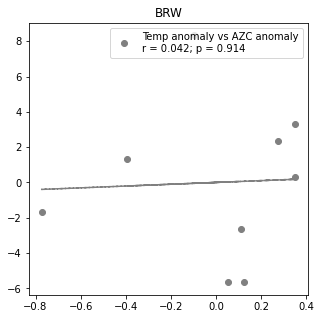

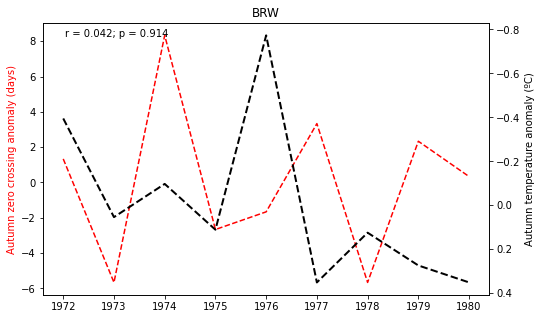

In [93]:
make_plots(station=corr_station, stations=stations, start_year=corr_start, end_year=corr_end, ccg_output=ccg_output,
    tmp_per_station=tmp_per_station, common_tmp_file=common_tmp_file, data_dir=data_dir, detrend=detrend, name=name, tx=0.05)